In [2]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import scipy.signal
import scipy as scp

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Friction classes for alternative friction laws:
class SlipWeakeningFrictionLaw: 
    
    def __init__(self,dc,delta_u):
        self.dc = dc
        self.delta_u = delta_u
        
    def getFriction(self,x,u,v,tau,stuck):
        frictionForce = np.sign(v)*(1-self.delta_u/self.dc)
        frictionForce[frictionForce<0]=0
        return frictionForce
    
    def step(self,x,u,v,tau,stuck,dt):
        self.delta_u = self.delta_u + v*dt
        self.delta_u[stuck==1]=0 #Arrest sets delta_u to zero
        return

In [5]:
#Gauss distribution for setting up initial stress
def gauss(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))
        

In [264]:
# Create pulse prediction function
def PulsePrediction(startPos,u,x,tau,gamma,dc=0):
    u_pred = np.zeros(np.size(x))
    u_pred[startPos]=u[startPos,-1]
    if len([dc])==1:
        dc = dc*np.ones(np.size(x))

    for i in range(startPos+1,len(x)):        
        dx = x[i]-x[i-1]
        u_pred[i] = u_pred[i-1] + (tau[i-1] - .5*gamma*u_pred[i-1])*dx
        
        #Fracture energy mod:
#       if u_pred[i-1]<dc[i-1]:
#            u_pred[i] = u_pred[i] - (1 - .5*(1-u_pred[i-1]/(2*dc[i-1])))*dx
#        else:
#            u_pred[i] = u_pred[i] - .5*dc[i-1]/(u_pred[i-1])*dx
            
        if u_pred[i-1]<dc[i-1]:
            u_pred[i] = u_pred[i] - (1 - .5*(1-u_pred[i-1]/(2*dc[i-1])))*dx
        else:
            u_pred[i] = u_pred[i] - .5*np.sqrt(dc[i-1])/(np.sqrt(u_pred[i-1]))*dx

    
    # Prediction of arrest where u_pred<0
    try:
        ind = np.where(u_pred<0)
        u_pred[ind[0][0]:]=0
    except:
        pass
    
    return u_pred

In [7]:
def seismicMoment(data):
    L = data['x'][np.sum(np.cumsum(data['stuck']==0,1)>0,0)-1]
    u_ave = np.array([np.mean(u[u>0]) for u in np.transpose(data['u'])])
    M = u_ave*L
    M_rate = np.gradient(u_ave*L)/np.gradient(data['t'])

    return {'L': L,
            'u_ave': u_ave,
            'M': M,
            'M_rate': M_rate}

# Figures for sketch
Example simulation with the relevant measures we will use later. I'm not really sure what should go into the sketch, but that should be decided once we have chosen the rest anyway.

In [90]:
# Set up and plot prestress distribution
x = np.linspace(0,50,1000)
tau = gauss(x,0,1)*.1+.9 - (2*x)/np.max(x)*.9

#tau = gauss(x,0,20)*5-4
tau = tau/np.max(tau) # Make sure tau reaches 1, which is needed for t
tau[x<1]=1

# Set up fracture energy distribution (through dc)
dc = np.ones(np.size(tau))


dc[x<15] = gauss(x[x<15],15,.01)*(.1e-3-1e-3)+1e-3
dc[x>=15]=1e-3
dc = dc*0+1e-2



In [91]:
# Run simulation with gamma = 0.65
data = run.run_continuum(x = x, 
                         tau = tau, 
                         tau_minus = tau+2, 
                         dt = 1e-3, 
                         output_interval = 100,
                         gamma = 0.9,
                         tmax = 50, 
                         beta = 1e-2,
                         bc='fixed',
                         frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x))))

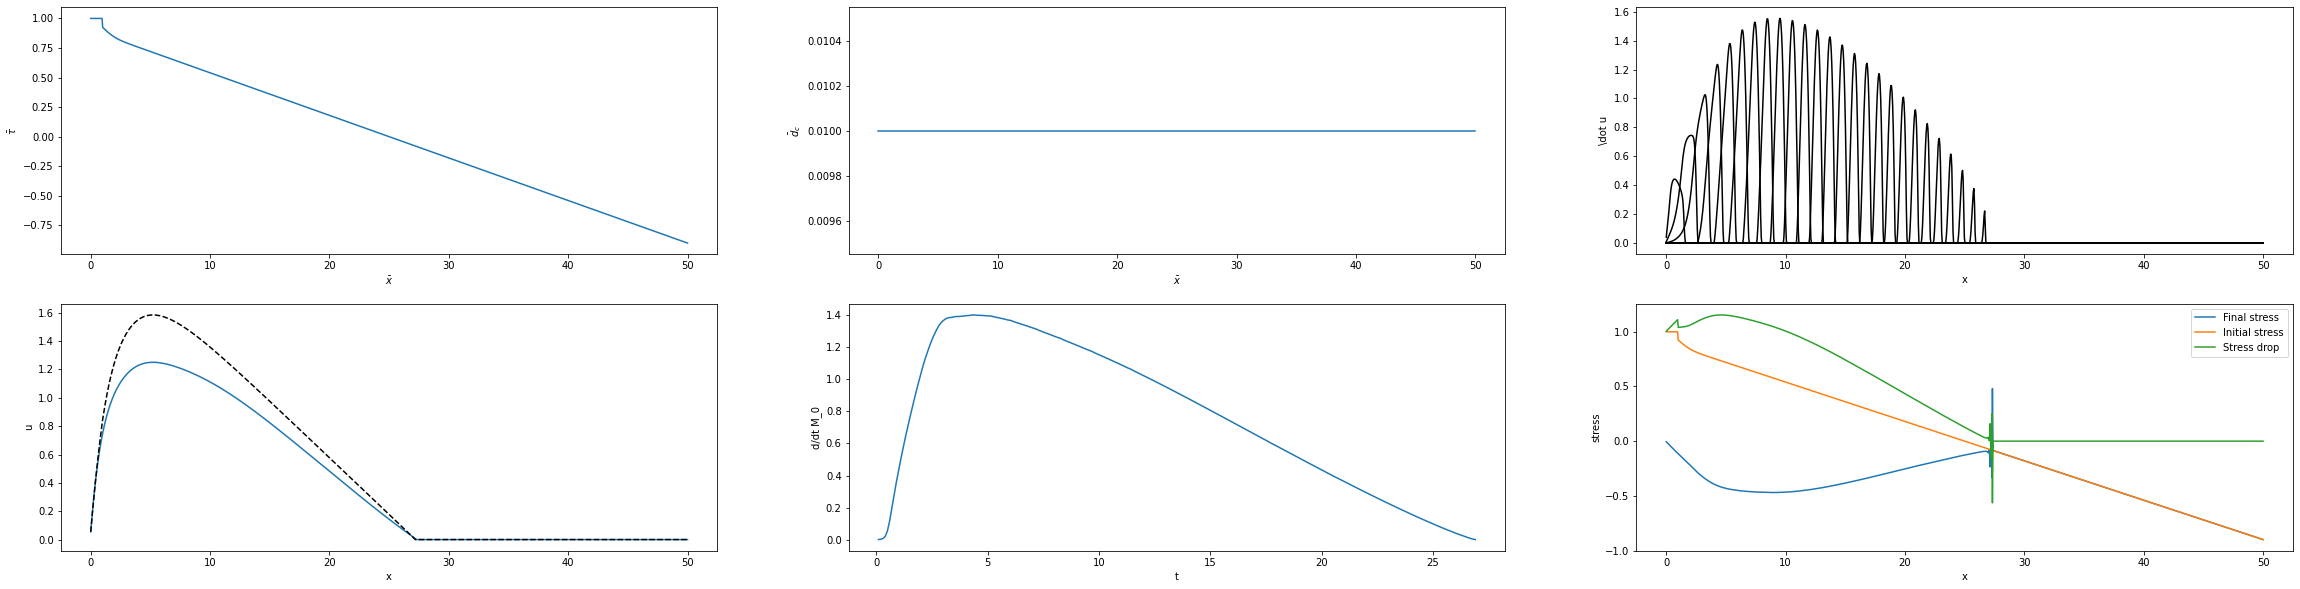

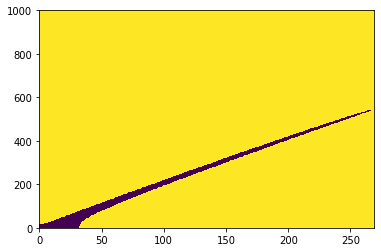

In [190]:
# Pulse velocity for different times
plt.figure(figsize=(40,10))
plt.subplot(2,3,1)
plt.plot(data['x'],data['tau'])
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar \\tau$')


# dc
plt.subplot(2,3,2)
plt.plot(data['x'],data['frictionLaw'].dc)
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar d_c$')

plt.subplot(2,3,3)
Nmax = len(data['t'])
plt.plot(data['x'],data['v'][:,range(0,Nmax-1,10)],'k')
plt.xlabel('x')
plt.ylabel('\dot u')

# Final slip
plt.subplot(2,3,4)
plt.plot(data['x'],data['u'][:,-1])
plt.xlabel('x')
plt.ylabel('u')
u_pred = PulsePrediction(startPos = 0, u = data['u'], x = data['x'],tau = data['tau'], gamma = data['gamma'],dc=data['frictionLaw'].dc)
plt.plot(data['x'],u_pred,'--k')



# Moment rate:
M = seismicMoment(data)
plt.subplot(2,3,5)
plt.plot(data['t'],M['M_rate'])
plt.ylabel('d/dt M_0')
plt.xlabel('t')


# Stress drop:
plt.subplot(2,3,6)
plt.plot(data['x'],data['a'][:,-1],label='Final stress')
plt.plot(data['x'],data['tau'],label='Initial stress')
plt.plot(data['x'],data['tau']-data['a'][:,-1], label='Stress drop')
plt.ylabel('stress')
plt.xlabel('x')
plt.legend()






plt.show()

plt.pcolor(data['stuck'])
plt.show()

# Predictions for rupture arrest


## Pulse eom
The final slip has above been compared to the slip assuming steady state at all times: $2\tau/\gamma$ (this comes from steady state solution of slip pulse).
Already from this it is quite clear that the final slip distribution will at least in some form resemble the initial shear stress. For small spatial variations in prestress, this prediction is atually fairly accurate. The first order prediction assuming slowly varying prestress of where the pulse will arrest is the first point where the non-dimensional prestress drops below zero, which is a very local criterion.

To obtain higher order approximations, there are a few possibilities. One is to find a pulse energy equation as in the fairly recent Heaton paper. It is, however, possible to perform a correction to the approximation used above. A final slip $2\tau/\gamma$ assumes no variation of prestress and neglects stress from du/dx. If we instead assume that the stress drop predicted from the steady state slip pulse is correct at all times, we can correct the solution with $\partial u \partial x$.

## Derivation
Steady state:
\begin{equation}
\frac{2\tau}{\gamma} = u
\end{equation}
or in terms of stress
\begin{equation}
2\tau = u\gamma
\end{equation}
In steady state, the applied stress through $\tau$ enters the leaf spring (because u(x) is constant). If $\gamma u \neq 2\tau$, assuming stress balance still applies, this stress is realized as extension and compresion of regions behind and in front of the pulse, resulting in the following stress balance equation
\begin{equation}
2\tau = u_p \gamma + 2 \frac{\partial u_p}{\partial x}
\end{equation}

Note that $u_p$ here is the final slip/ total slip of a passing pulse. u is thus different from the u in the equation of motion.  This equation implicitly assumes that the pulse can be considered a point. In the limit of a vanishing pulse width, $u(x) \rightarrow u_p(x)$

We can also modify the equation to include a non-zero fracture energy. This can be done by averaging the additional friction component over time and use an effective 
\begin{equation}
\bar \tau_\text{eff} = \bar \tau - \langle \bar f_f \rangle_t
\end{equation}
With the correction, we use the same stress balance equation as before
\begin{equation}
2\tau_\text{eff} = u_p \gamma + 2 \frac{\partial u_p}{\partial x}
\end{equation}
The equation can be solved as a space-integrated problem with typical initial condition set to u(0)=0.
The accuracy of the prediction then depends on the accuracy of the time-average. An accurate solution requires knowledge of slip as a function of time locally. For a non-zero fracture energy, we don't have this solution, but we can make some approximations.

First, we can average over slip if we assume that the slip speed is constant.
The value averaged over slip is 
\begin{equation}
\tau_\text{eff} = \tau - 1-u_p/(2d_c)
\end{equation}
when $\Delta u < d_c$, and else:
\begin{equation}
\tau_\text{eff} = \tau - dc/(2u)
\end{equation}
This approximation is in some cases an OK first order esimate of the time-average (because it assumes constant slip speed), but it is possible we can do better and make a correction to this.

One first order correction is to assume that acceleration is when we weight the contribution below $d_c$ with the contribution above $d_c$. instead of slip speed, which introduces a square root ratio of slip distance. This increases the weight of friction at small slip.
\begin{equation}
\tau_\text{eff} = \tau - 1-u_p/(2d_c)
\end{equation}
when $\Delta u < d_c$, and else:
\begin{equation}
\tau_\text{eff} = \tau - \sqrt{d_c}/(2\sqrt{u})
\end{equation}
which in some cases improves the prediction slightly. However, it is not straightforward to make a selection here. As we will see later, the pulse can slow down and  introduce an asymmetric velocity profile for higher fracture energies, which makes it possible to realize a larger stress drop than the prediction assumes. One could probably spend alot of time finding a better approximation, but there is always a question what we learn from doing that. I'll leave it like this for now.

## Pulse propagation and prediction of arrest location and final slip

In [568]:
# Create a small dataset with different decaying taubar
N_runs = 7
dataPulse = []

for xmax in range(20,100,N_runs):
    
    x = np.linspace(0,xmax,1000)
    tmax = xmax*3

    # Create linear tau:
    tau = 1-(2*x)/np.max(x)*.7
#    tau = gauss(x,0,1)*.1+.9 - (2*x)/np.max(x)*.9
    tau = tau/np.max(tau) # Make sure tau reaches 1, which is needed for t

    # run
    dataPulse.append(run.run_continuum(x = x,
                                       tau = tau,
                                       tau_minus = tau+2,
                                       dt = 1e-3,
                                       output_interval = 100,
                                       gamma = 0.9,
                                       tmax = tmax,
                                       beta = 1e-2,
                                       bc='fixed',
                                       frictionLaw = SlipWeakeningFrictionLaw(dc=1e-3,delta_u = np.zeros(np.size(x))) ) )

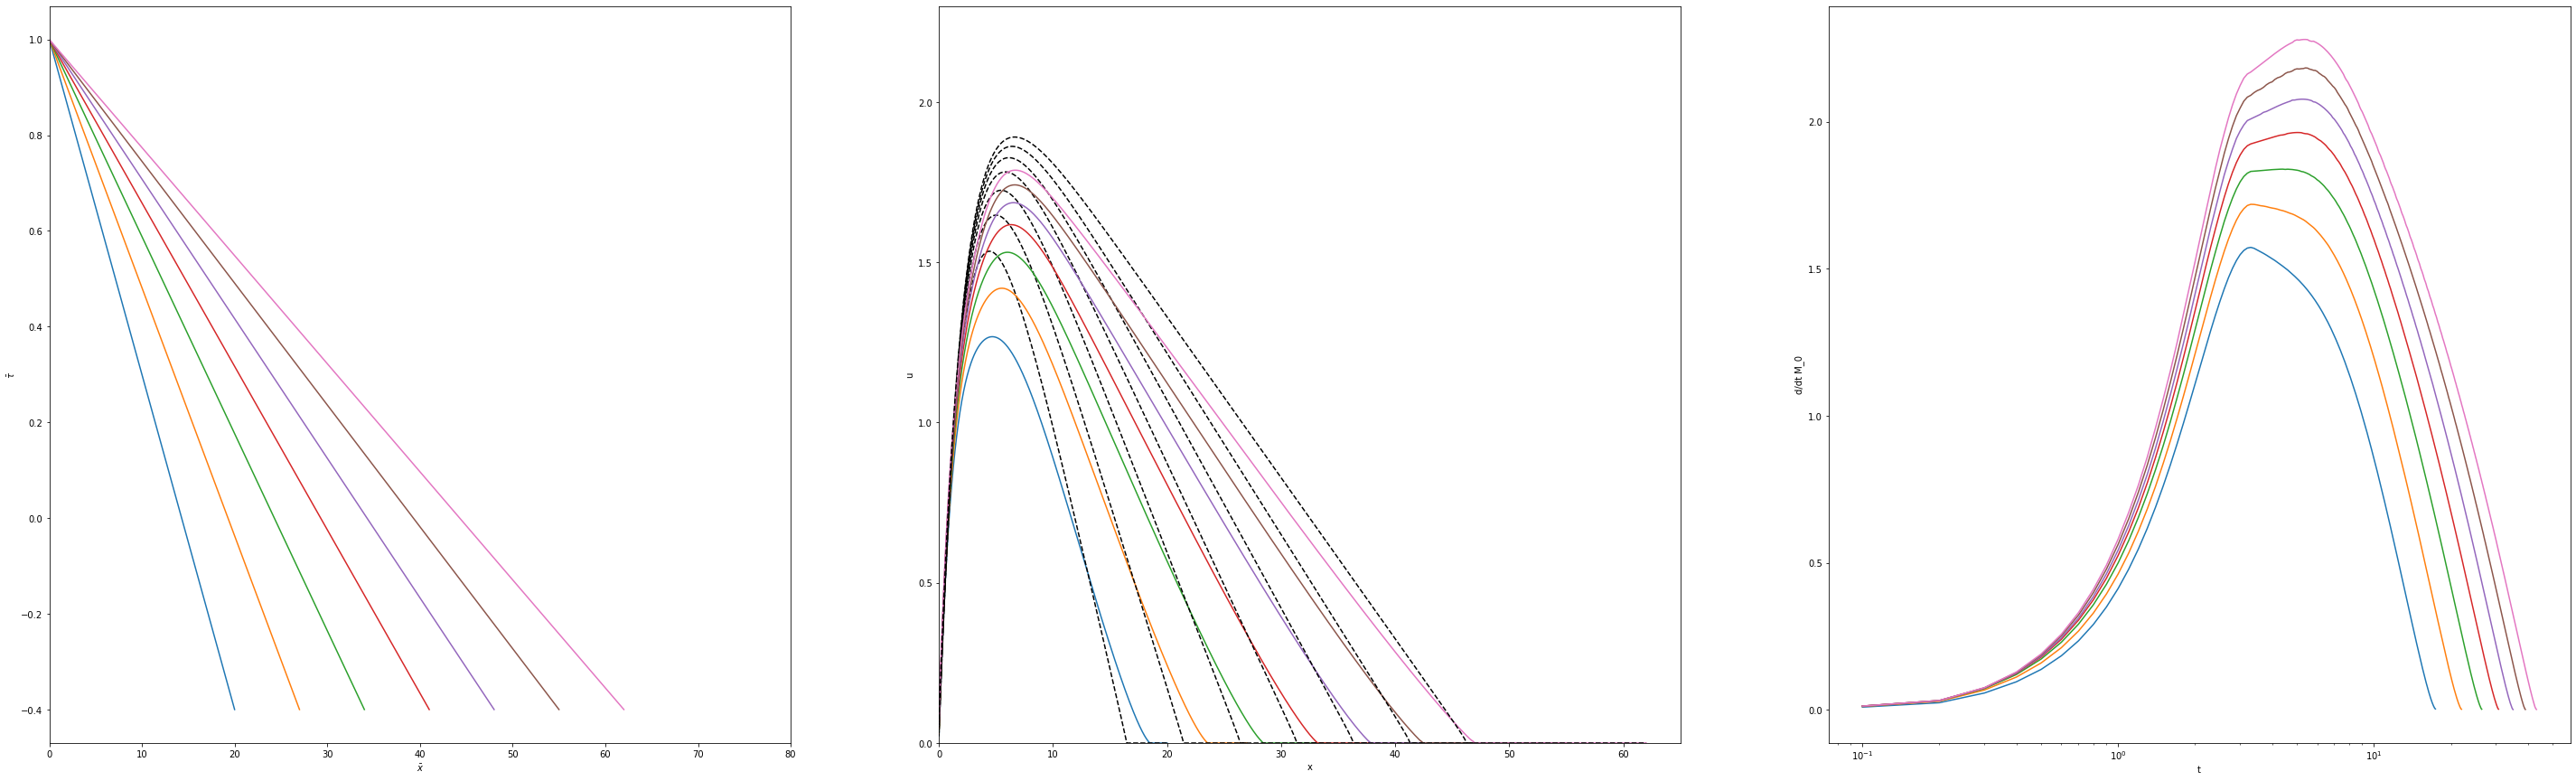

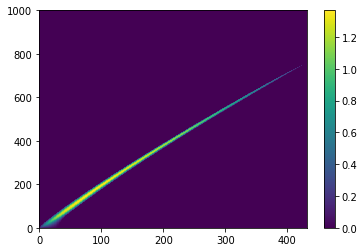

In [569]:
# Plot some example pulses
plt.figure(figsize=(50,15))

plt.subplot(1,3,1)
for runInd in range(N_runs):
    plt.plot(dataPulse[runInd]['x'],dataPulse[runInd]['tau'])

plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar \\tau$')
plt.xlim([0,80])

plt.subplot(1,3,2)
for runInd in range(N_runs):
    Nmax = len(dataPulse[runInd]['t'])
    plt.plot(dataPulse[runInd]['x'],dataPulse[runInd]['u'][:,-1])
    u_pred = PulsePrediction(startPos = 0, u = dataPulse[runInd]['u'], x = dataPulse[runInd]['x'],tau = dataPulse[runInd]['tau'], gamma = dataPulse[runInd]['gamma'],dc = dataPulse[runInd]['frictionLaw'].dc)
    plt.plot(dataPulse[runInd]['x'],u_pred,'--k')

plt.xlabel('x')
plt.ylabel('u')
plt.xlim([0,65])
plt.ylim([0,2.3])

plt.subplot(1,3,3)
for runInd in range(N_runs):
    M = seismicMoment(dataPulse[runInd])
    Nmax = len(dataPulse[runInd]['t'])
    plt.plot(dataPulse[runInd]['t'],M['M_rate'])

plt.ylabel('d/dt M_0')
plt.xlabel('t')
#plt.xlim([0,25])
#plt.ylim([0,6])
#plt.yscale('log')
plt.xscale('log')

plt.show()


plt.pcolor(dataPulse[runInd]['v'])
plt.colorbar()
plt.show()

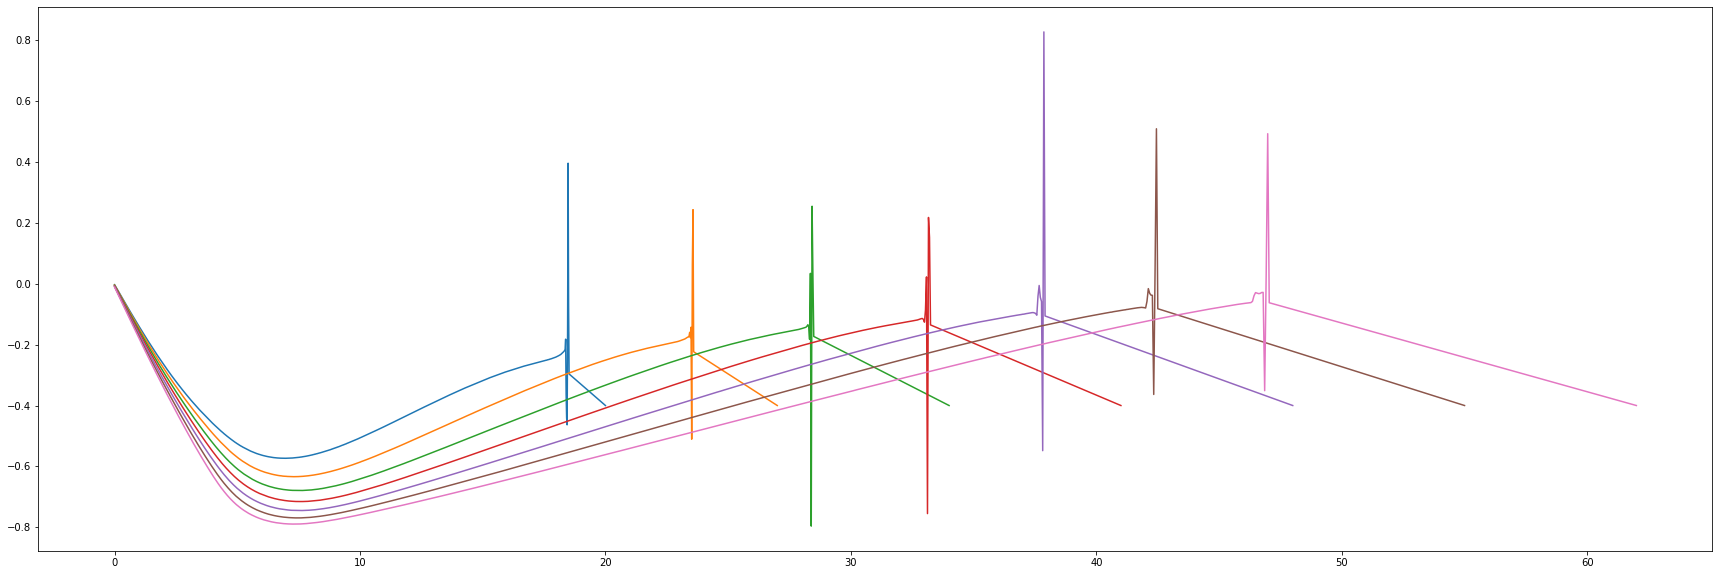

In [570]:
plt.figure(figsize=(30,10))
for runInd in range(N_runs):
    M = seismicMoment(dataPulse[runInd])
    
#    plt.plot(M['M'][-1],np.sum(dataPulse[runInd]['tau']-dataPulse[runInd]['a'][:,-1]),'o')
    plt.plot(dataPulse[runInd]['x'],dataPulse[runInd]['a'][:,-1])
    
plt.show()

The agreement between predicted and measured slip is fairly good, but it will probably be slightly worse if we increase the frequency of the noise in tau because we do not account for the finite pulse width.


# Relation to predictability of EQ:
Difficult to see any difference at short times, even with this simple example. Solutions are in principle distinguishable, but with noise on top it will be extremely difficult to predict size at short times. What we are doing in practice if we try to predict size based on slip/moment rate so far is to try to predict the slope of the prestress in regions in front of the pulse based on the prestress encountered so far. Such extrapolation will in many cases work (is my guess), but it always comes with the danger of quite strong assumptions on what the stress field looks like (it should be similar shape for all the EQs considered, whatever that means in practice). In particular, this will be sensitive to the functional form of prestress for small times, which based on typical nucleation criteria could very well be very similar for events of all sizes.


## Analytical prediction of moment rate vs time for linearly decaying prestress
Assuming rupture starts at $x=0$, we have for a linearly decaying prestress:
\begin{equation}
2(1-x/x_0) = 2 \frac{\partial u}{\partial x} + \gamma u
\end{equation}
with $u(0)=0$, which has the solution

\begin{equation}
u(x) = \frac{x_0 \gamma (2-2e^{-(\gamma x)/2}) - 4e^{-(\gamma x)/2} - 2\gamma x + 4}{x_0 \gamma^2}
\end{equation}

which is valid as long as $u(x)>0$.


@TODO: Can we find moment rate from this? We have the slip, but also need the distance propagated (need front speed). We can alternatively find the moment rate as a function of front position instead.



@TODO: Discuss the equation a bit. Can we separate it in two stages? Acceleration and decceleration?



# Stress barriers
### How can a (stress) barrier stop a pulse?
This can be understood from the pulse equation (for the prediction of pulse evolution).
\begin{equation}
2\tau = 2 \frac{\partial u}{\partial x} + \gamma u
\end{equation}

if a pulse with local slip $u$ enters a barrier represented by a region of negative (constant) $\tau = \tau_{barrier}$ in a region 

$x \in [0,L_{barrier}]$,

we can solve
\begin{equation}
\frac{\partial u}{\partial x} =  \tau_{barrier} - \frac{1}{2}\gamma u
\end{equation}
for where $u = 0$ to find the propagation distance into the barrier.

The evolution of slip is:
\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} + c_1 e^{-\gamma x / 2}
\end{equation}

This applies for any value of $\tau_{barrier} \in (-1,1)$ (it doesn't have to be a barrier), and actually answers to some degree what the relevant length scale of pre-stress fluctuations is. Slip changes exponentially, and the characteristic length scale for changes in slip for a propagating pulse is $2/\gamma$. (a finite width of the pulse can alter this, though)

We can insert for the constant $c_1$ by instead using the initial slip $u(0)$
\begin{equation}
c_1 = u(0) - \frac{2\tau_{barrier}}{\gamma}
\end{equation}


so that 
\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} + (u(0) - \frac{2\tau_{barrier}}{\gamma}) e^{-\gamma x / 2}
\end{equation}


\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2}) + u(0)e^{-\gamma x / 2}
\end{equation}



We can then find the maximum size of the barrier which cannot stop the pulse:
\begin{equation}
0 = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2}) + u(0)e^{-\gamma x / 2}
\end{equation}
\begin{equation}
-u(0)e^{-\gamma x / 2} = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2})
\end{equation}
With the constraints $c_1>0$, $\tau_{barrier}<0$ and $\gamma >0$, we find the solution

\begin{equation}
L_{arrest} = \frac{2 \log(-\frac{\gamma (u(0) - \frac{2\tau_{barrier}}{\gamma})}{2\tau_{barrier}})}{\gamma}
\end{equation}


We can now set up a few simple numeriments to test this relation:








In [182]:
# Create a small dataset with different barrier sizes

dt = 1e-3
tmax = 50
gamma = 0.8
beta = 0.1
output_interval = 100
N_runs = 2
dataBarrier = []

for runInd in range(N_runs):
    x = np.linspace(0,100,1000)
#    tau = gauss(x,0,1)*.5 +.5 - gauss(x,25,1)*(.6+.4*runInd)
    tau = gauss(x,0,1)*.5 +.5
    
    tau[0]=1
    
    
    tau[300:350]=-.1*runInd
    
    tau[600:]=-.9

    # run
    dataBarrier.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))

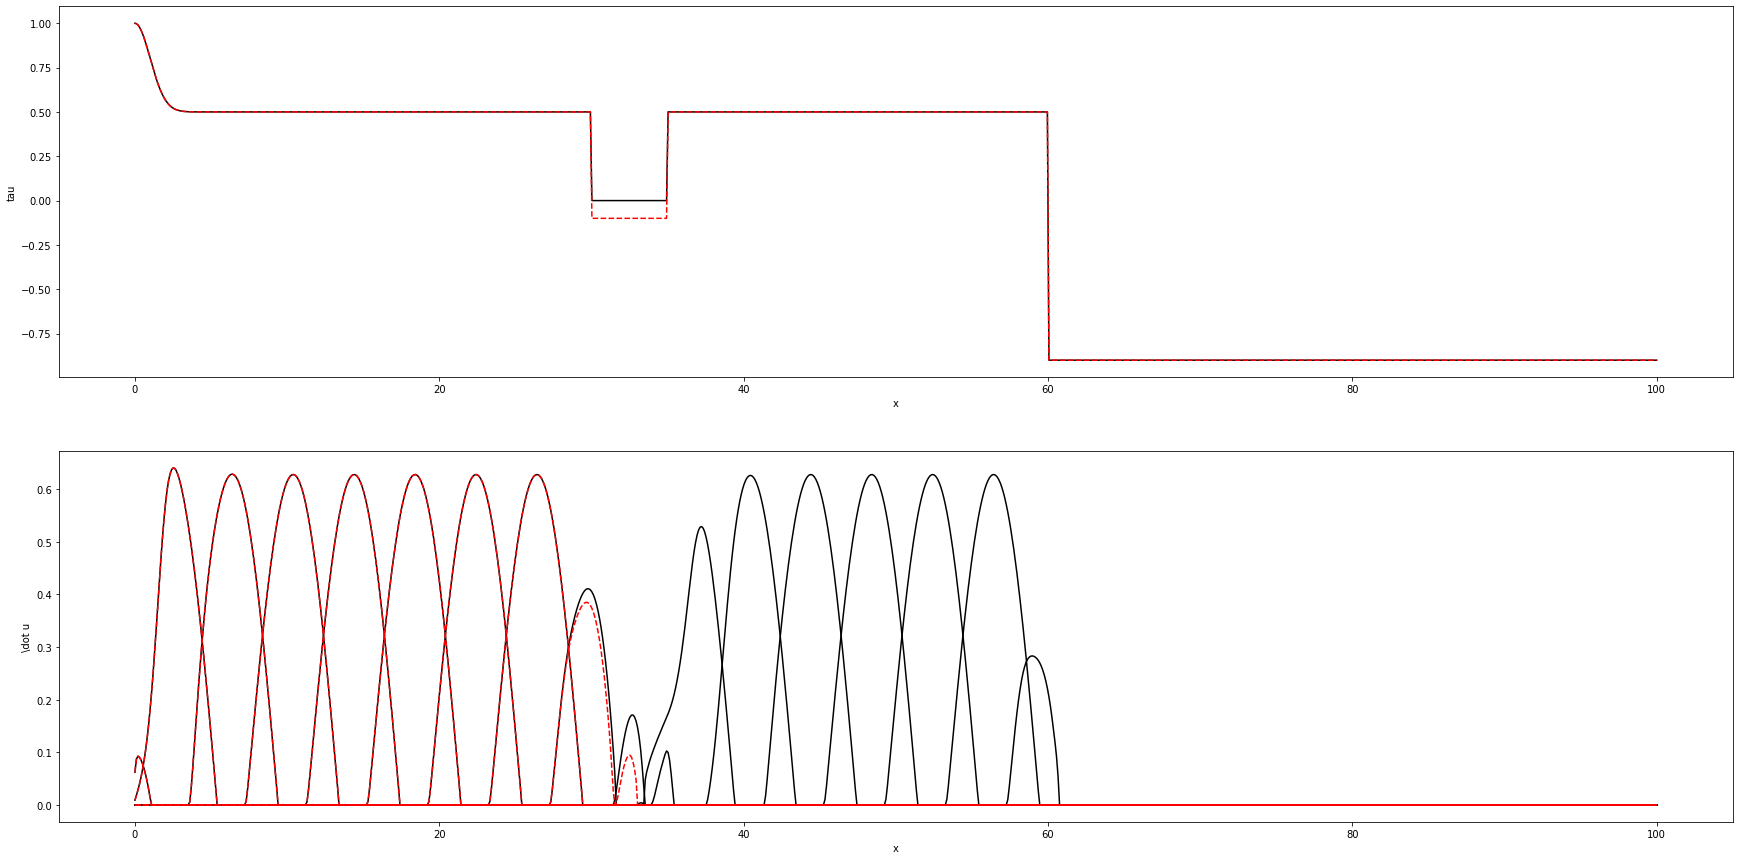

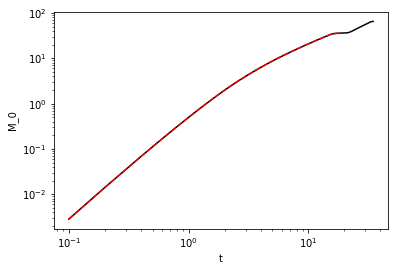

In [183]:
# Plot
plt.figure(figsize=(30,15))
color = ['-k','--r']


ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for runInd in range(N_runs):
    ax1.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['tau'],color[runInd])
    Nmax = len(dataBarrier[runInd]['t'])
    ax2.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['v'][:,range(0,Nmax-1,20)],color[runInd])

ax1.set_ylabel('tau')
ax1.set_xlabel('x')

ax2.set_ylabel('\dot u')
ax2.set_xlabel('x')
    
plt.show()



# Plot also the moment rate for illustration:
for runInd in range(N_runs):

    M = seismicMoment(dataBarrier[runInd])
    plt.plot(dataBarrier[runInd]['t'],M['M'],color[runInd])
    
plt.ylabel('M_0')
plt.xlabel('t')
plt.yscale('log')
plt.xscale('log')
plt.show()

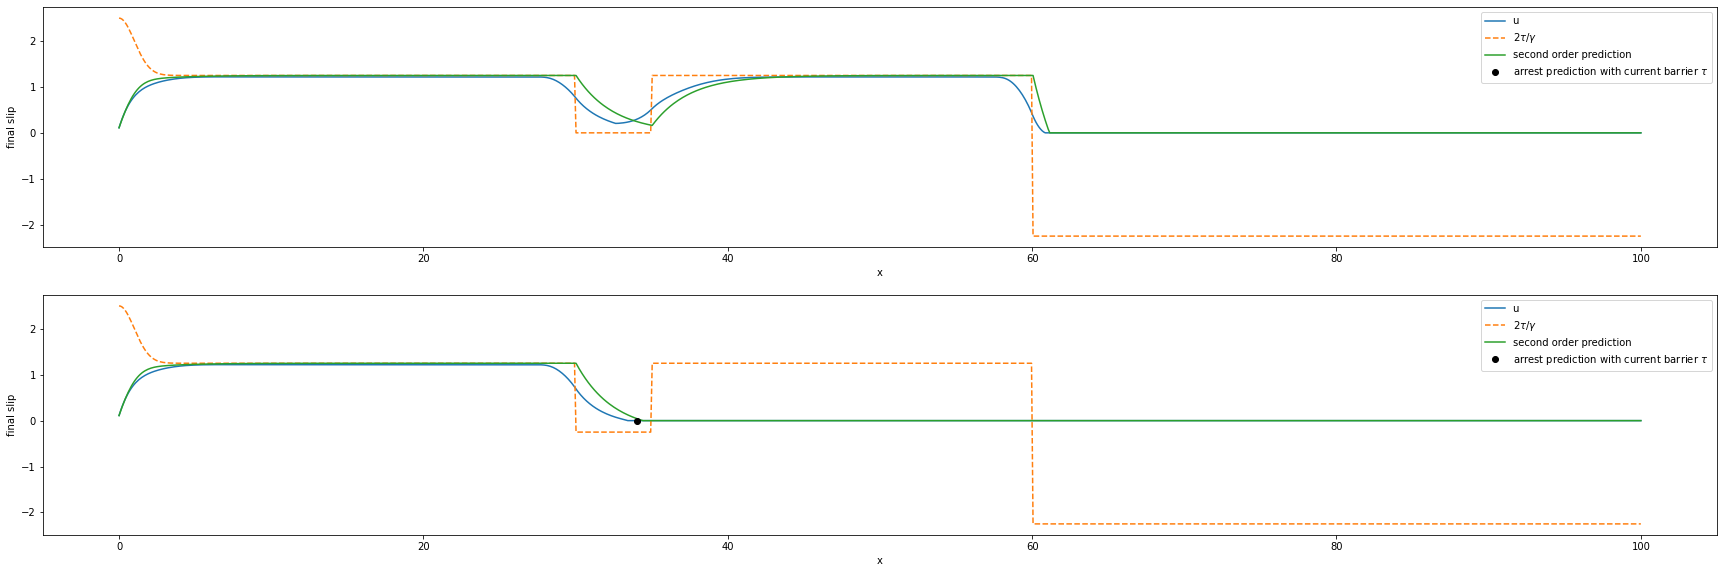

In [184]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    start = 0
    
    # calculate prediction:
    xP = dataBarrier[runInd]['x']
    tau = dataBarrier[runInd]['tau']
    gamma = dataBarrier[runInd]['gamma']
    u_pred = np.zeros(np.size(xP))
    u_pred[start]=dataBarrier[runInd]['u'][start,-1];

    for i in range(start+1,len(xP)):
        stress_drop = 2*tau[i-1]
        dxP = xP[i]-xP[i-1]
        u_pred[i] = u_pred[i-1] + .5*(stress_drop - gamma*u_pred[i-1])*dxP
    
    # Prediction of arrest where u_pred<0
    try:
        ind = np.where(u_pred<0)
        u_pred[ind[0][0]:]=0
    except:
        pass
    
    L_arrest = 2*np.log(-(dataBarrier[runInd]['u'][299,-1] - 2*dataBarrier[runInd]['tau'][300]/dataBarrier[runInd]['gamma'])/(2*dataBarrier[runInd]['tau'][300]))/dataBarrier[runInd]['gamma']
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['u'][:,-1],label='u')

    plt.plot(dataBarrier[runInd]['x'],2*dataBarrier[runInd]['tau']/dataBarrier[runInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataBarrier[runInd]['x'],u_pred,label='second order prediction',linestyle='-')
    plt.plot(dataBarrier[runInd]['x'][300]+L_arrest,0,'ok',label='arrest prediction with current barrier $\\tau$')
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    
    plt.legend()
plt.show()


# TODO: PLot the prediction of arrest in the same figure.

## Arrest phase diagram:

We set up pulses for arrest using the steady state solution (choose $u(0) = 2\tau/\gamma$). This reduces the arrest length approximation to

\begin{equation}
L_{arrest} = \frac{2 \log(\frac{\tau_{barrier} - \tau}{\tau_{barrier}})}{\gamma}
\end{equation}

In the following, we set up a fixed $\gamma = 0.7$ and vary $\tau$ and $\tau_{barrier}$ to create a 2D phase diagram of the arrest length


In [14]:
import time
dt = 1e-3
tmax = 100
gamma = 0.8
beta = 0.1
output_interval = 100
x = np.linspace(0,100,1000)
barrierInd = 300

tau_all = np.linspace(0.1,.9,10)
tau_barrier_all = -np.linspace(0.1,.9,10)

L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])
L_prediction = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

for i in range(np.size(tau_all)):
#    print(i)
    for j in range(np.size(tau_barrier_all)):

        tau = tau_all[i]*np.ones(np.size(x))
        tau[0:10]=1
    
        tau[barrierInd:]=tau_barrier_all[j]

        # run
        t = time.time()
        # do stuff

        data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
#        print(time.time() - t)
    
        # Find L_arrest
        L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]-x[barrierInd]
        
        # Calculate prediction:
        L_prediction[i,j]=2/gamma*np.log((tau_barrier_all[j]-tau_all[i])/tau_barrier_all[j])

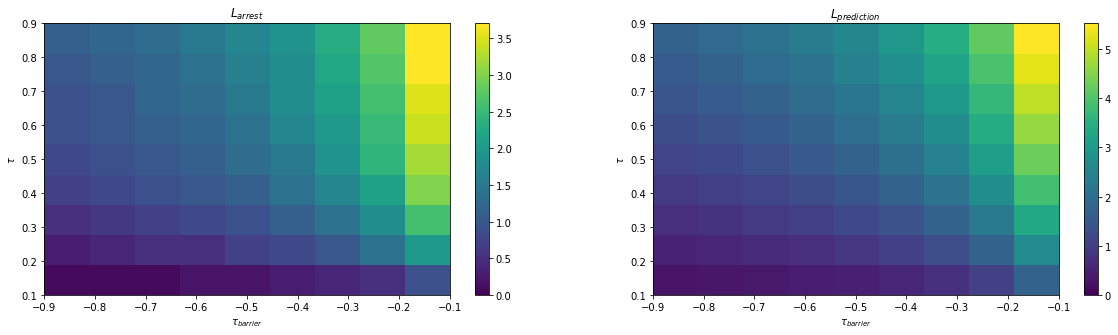

In [15]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.pcolor(tau_barrier_all,tau_all,L_arrest,vmin=0)
plt.colorbar()
plt.xlabel('$\\tau_{barrier}$')
plt.ylabel('$\\tau$')
plt.title('$L_{arrest}$')

plt.subplot(1,2,2)
plt.pcolor(tau_barrier_all,tau_all,L_prediction,vmin=0)
plt.colorbar()
plt.xlabel('$\\tau_{barrier}$')
plt.ylabel('$\\tau$')
plt.title('$L_{prediction}$')
plt.show()

The next we can do is to select a size of the barrier $L$, and measure the arrest length only if the rupture stops:
    

In [16]:
dt = 1e-3
gamma = 0.8
beta = 0.1
output_interval = 100
tmax = 50
x = np.linspace(0,50,500)
barrierInd = 250
barrierEnd = 275
L_barrier = x[barrierEnd]-x[barrierInd]

tau_all = np.linspace(0.1,.9,10)
tau_barrier_all = -np.linspace(0.1,.9,10)

L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])
L_prediction = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

for i in range(np.size(tau_all)):
#    print(i)
    for j in range(np.size(tau_barrier_all)):

        tau = tau_all[i]*np.ones(np.size(x))
        tau[0:10]=1
    
        tau[barrierInd:]=tau_barrier_all[j]
        tau[barrierEnd:]=tau_all[i]
        tau[400:]=-.9

        # run
        t = time.time()
        # do stuff

        data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
#        print(time.time() - t)
    
        # Find L_arrest
        L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]-x[barrierInd]
        if L_arrest[i,j]>L_barrier:
            L_arrest[i,j]=-1

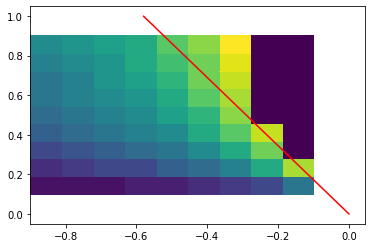

In [17]:
# Calculate prediction:
#exp(L_barrier*gamma/2) = (tau_barrier-tau)/tau_barrier
#tau_barrier*(1-exp(L_barrier*gamma/2)) = tau

plt.pcolor(tau_barrier_all,tau_all,L_arrest,vmin=0)
tb_plot = -np.linspace(0,1,1000)
t_plot = tb_plot*(1-np.exp(L_barrier*gamma/2))
t_plot[t_plot>1] = float('nan')
plt.plot(tb_plot,t_plot,'-r')

plt.show()

# Fracture energy barriers
In the above simulations, we asummed zero non-dimensional fracture energy. Here, we modify the barrier type by introducing a slip-weakening frition law with linear slip decay length $\bar d_c$, which gives a non-dimensional fracture energy $\bar G = \frac{\bar d_c}{2}$. As before, we keep the static friction coefficient constant, but add a step change in fracture energy along the interface.


In [259]:
# Create a small dataset with different fracture energy barrier sizes

dt = 1e-3
tmax = 100
gamma = 0.8
beta = 1e-2
output_interval = 100
N_runs = 10
dataBarrier = []

for runInd in range(N_runs):
    x = np.linspace(0,100,1000)
    tau = gauss(x,0,1)*.7 +.3
    tau[0]=1
    dc = (1e-2-1e-3)*gauss(x,40,5)*(2*runInd+1) + 1e-3
    dc[x>40]=1e-2*(2*runInd+1)
    tau[950:]=-.5

    # run
    dataBarrier.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta, bc='fixed',frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x)))))
    

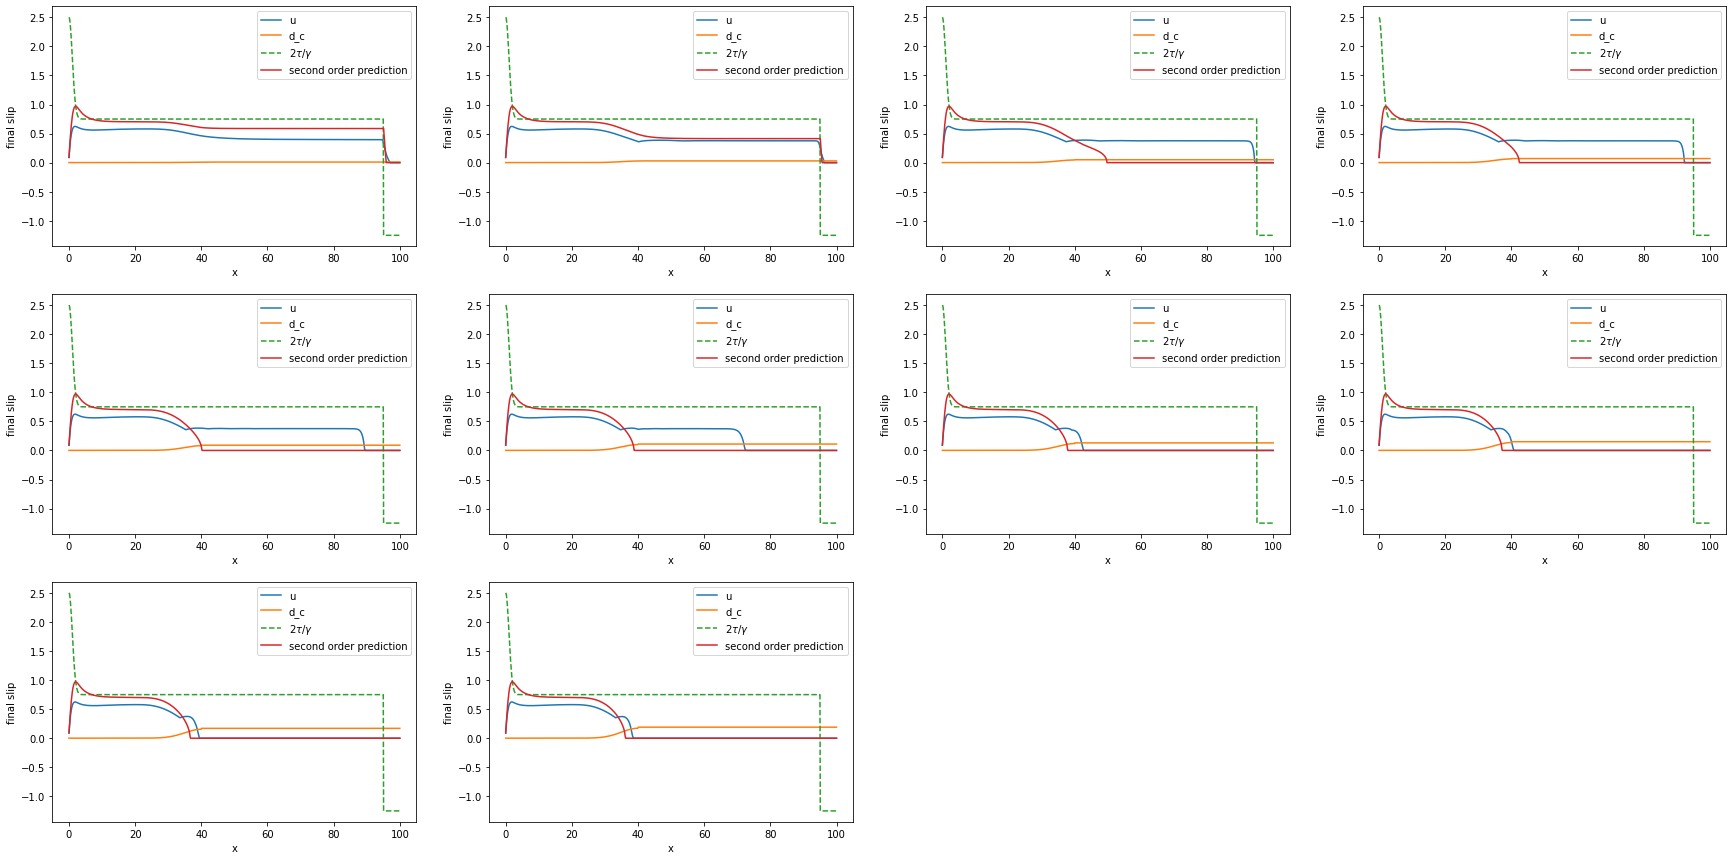

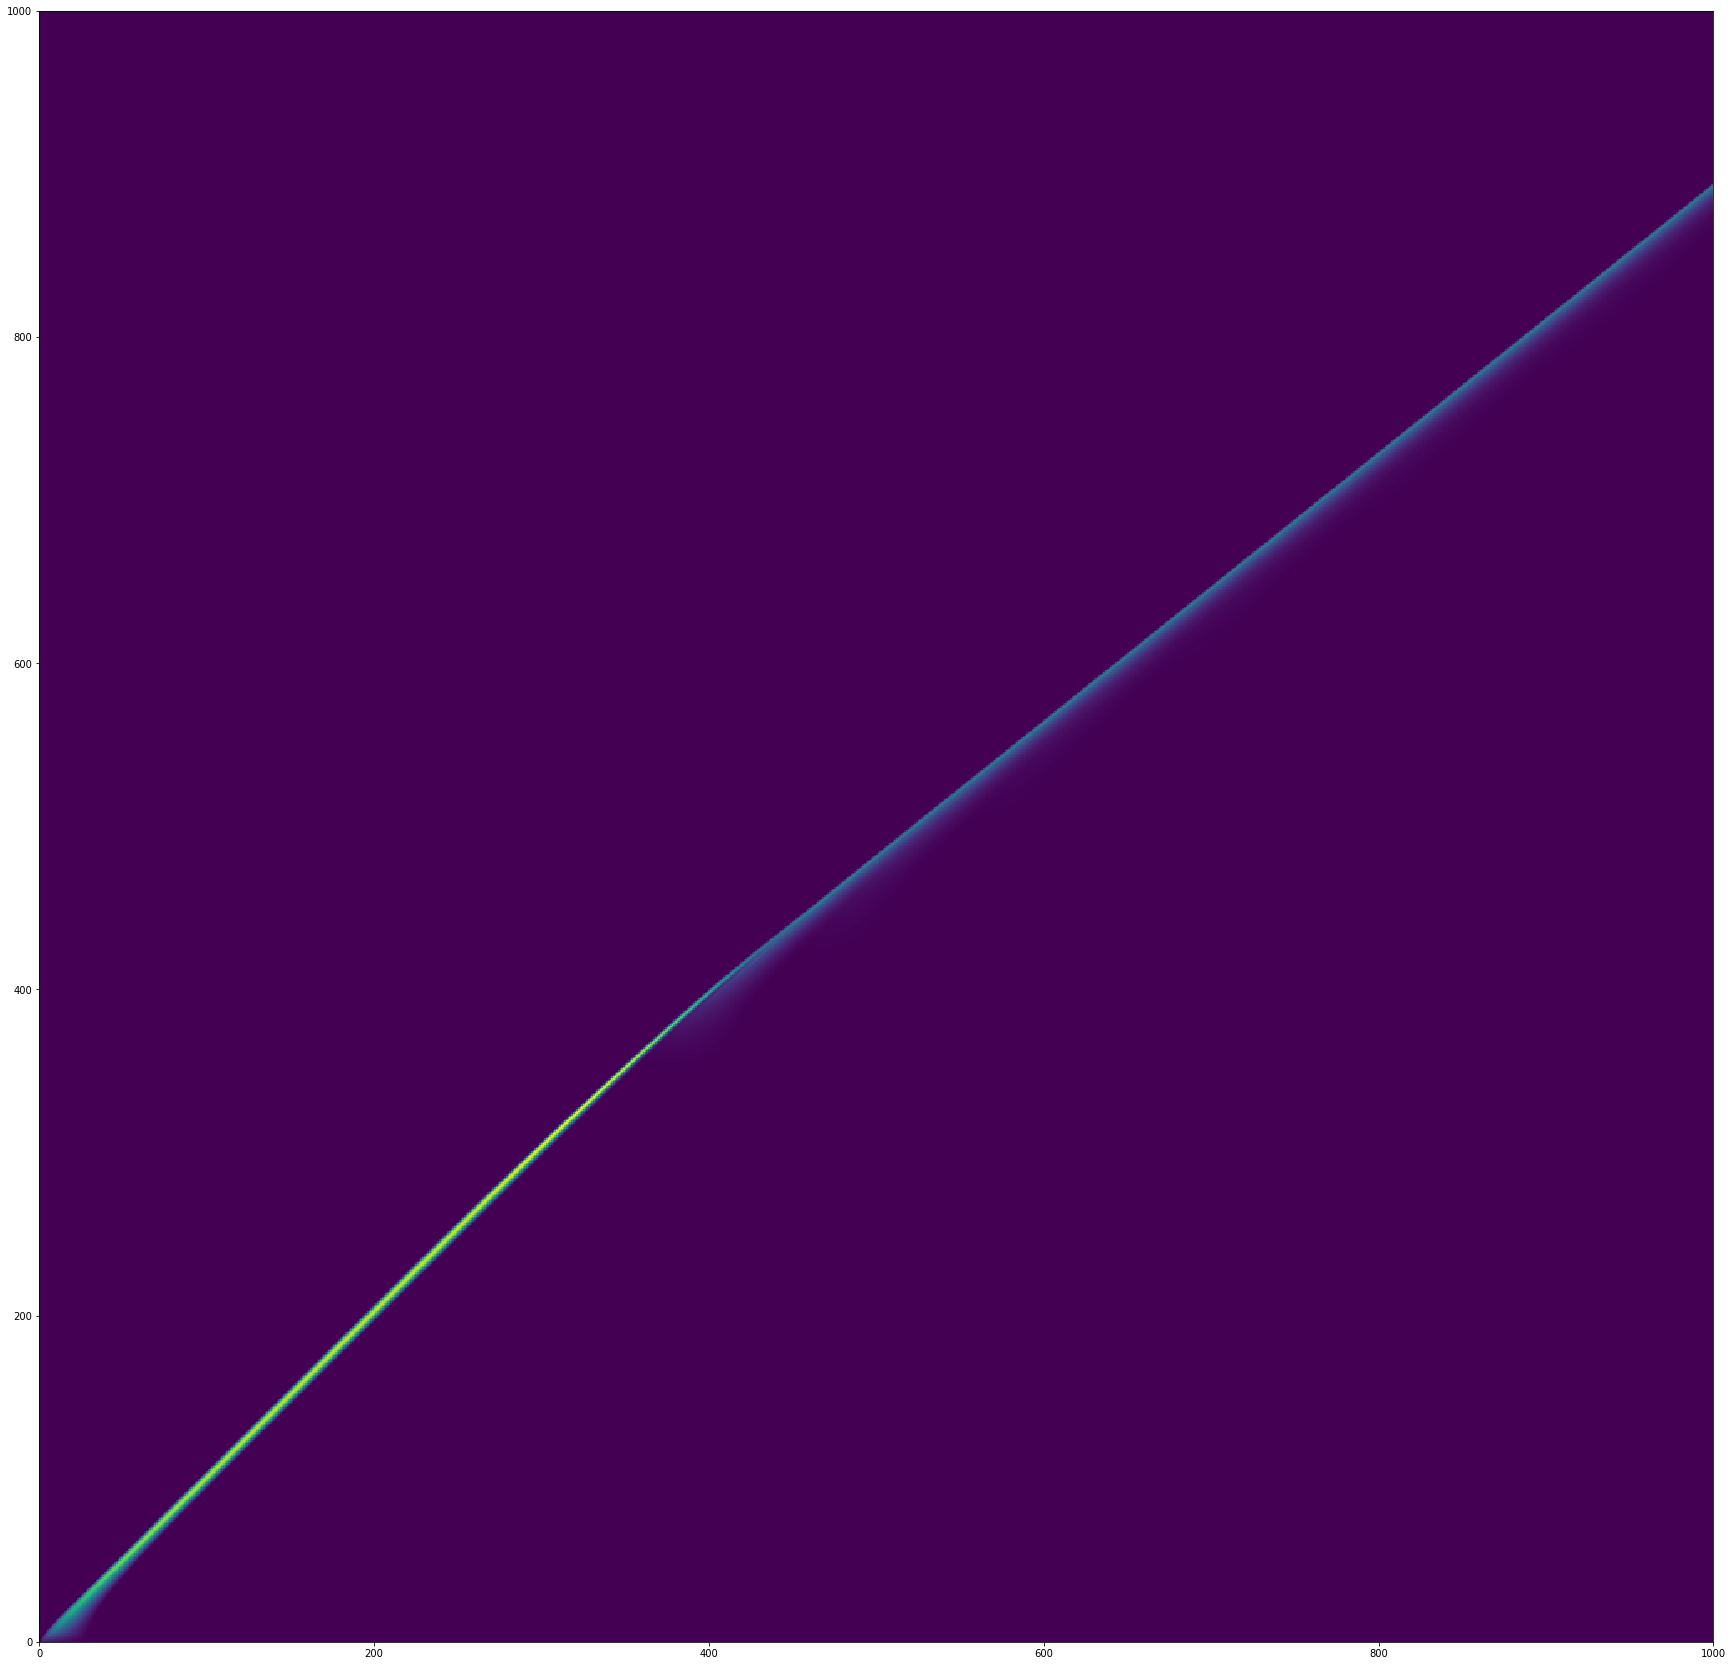

In [265]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    # calculate prediction:
    u_pred = PulsePrediction(startPos = 0, u = dataBarrier[runInd]['u'], x = dataBarrier[runInd]['x'],tau = dataBarrier[runInd]['tau'], gamma = dataBarrier[runInd]['gamma'],dc = dataBarrier[runInd]['frictionLaw'].dc)
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['u'][:,-1],label='u')
    plt.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['frictionLaw'].dc,label='d_c')

    plt.plot(dataBarrier[runInd]['x'],2*dataBarrier[runInd]['tau']/dataBarrier[runInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataBarrier[runInd]['x'],u_pred,label='second order prediction',linestyle='-')
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    
    plt.legend()
plt.show()


plt.figure(figsize=(30,30))
plt.pcolor(dataBarrier[4]['v'])
plt.show()
# TODO: PLot the prediction of arrest in the same figure

# Implications on predictability of pulse-like EQs, role of noise

The important wavelengths are found from the equations above. Include noise in linear decay simulations. Try different functional forms. Demonstrate that predictions are effectively the same as a qualifiedguess of the prestress using extrapolation.

For now, I test a few different things here, and we'll see where to go with the paper

In [18]:
# Create a small dataset with different sinusoidal sizes to test the variation in slip due to variations in prestress.

dt = 1e-3
tmax = 100
gamma = 0.8
beta = 0.01
output_interval = 100
N_runs = 20
dataSine = []
tau0 = .25

for runInd in range(N_runs):
    x = np.linspace(0,100,1000)
    tau = gauss(x,0,1)*(1-tau0) +tau0
    tau[100:] = tau0+tau0*np.cos((x[100:]-x[100])/((3*runInd+1)*.1))
    tau[0]=1

    # run
    dataSine.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))

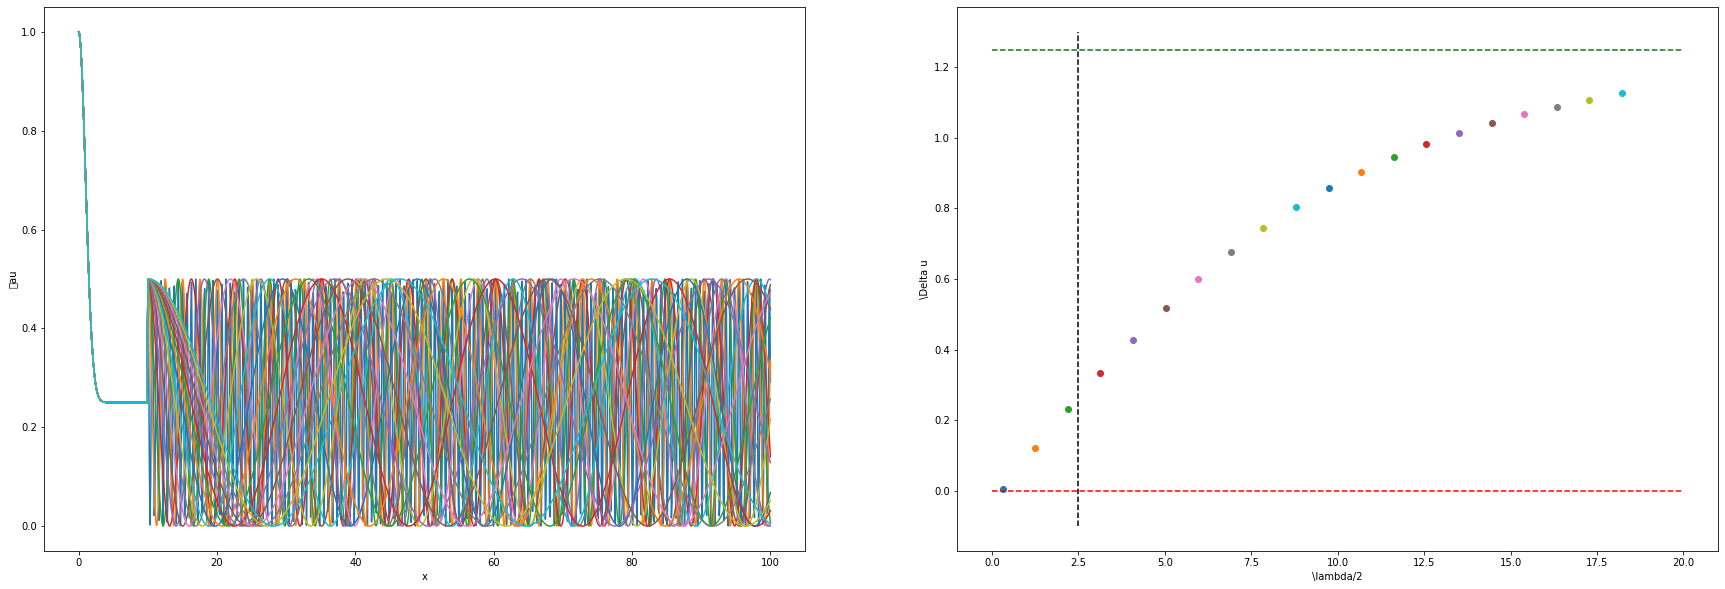

In [19]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
for runInd in range(N_runs):
    plt.plot(x,dataSine[runInd]['tau'])

plt.ylabel('\tau')
plt.xlabel('x')
    
    
plt.subplot(1,2,2)
for runInd in range(N_runs):
    
    max_u = np.max(dataSine[runInd]['u'],1)
    max_v = np.max(dataSine[runInd]['v'],1)
    plt.plot(2*np.pi*(3*runInd+1)*.1/2,np.max(max_u[200:800])-np.min(max_u[200:800]),'o')

plt.plot([0,20],[4*tau0/gamma,4*tau0/gamma],'--g')
plt.plot([0,20],[0,0],'--r')


plt.plot([2/gamma,2/gamma],[-.1,1.3],'--k')

plt.ylabel('\Delta u')
plt.xlabel('\lambda/2')
plt.show()    

#plt.pcolor(dataSine[0]['v'])
#plt.show()
#plt.pcolor(dataSine[runInd]['v'])
#plt.show()

## Predictability of EQs for noisy initial stress
What type of noise should we use? What is the best measure of predictability. Link this to extrapolation of initial stress

ZeroDivisionError: float division by zero